# Compare QTLs with and without cell populations
- V03: Add analysis of interaction terms
- V02: compare top hit (the same variant in both analyses)


In [1]:
setwd("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution")

In [2]:
invisible(suppressWarnings(file.link("/frazer01/home//matteo/notebooks/eqtls_deconvolution_gtex//analyze_qtl_results.ipynb", "analysis/analyze_qtl_results.ipynb")))

source("analysis/cardiac_qtls_packages.R"      )
source("analysis/cardiac_qtls_input_files.R"   )
source("analysis/cardiac_qtls_functions.R"     )
source("analysis/cardiac_qtls_input_data.R"    )
source("analysis/cardiac_qtls_load_metadata.R" )


Loading packages...
Loading input files...
Loading functions...
Loading input data...
Loading metadata...


In [3]:
nrow(read.table(paste("qtls/", "liver_original", "/analysis/egenes.", "liver_original", ".txt", sep = ""), header = TRUE))
nrow(read.table(paste("qtls/", "skin_original" , "/analysis/egenes.", "skin_original" , ".txt", sep = ""), header = TRUE))


[1] 19621

[1] 24029

In [4]:
tissues         = c("liver_original", "liver_cells", "liver2_cells", "liver3_cells", "skin_original", "skin_cells", "skin2_cells"  )
tissue2name     = data.frame(tissue = tissues, name = c("Liver (original)", "Liver (mouse cell populations)", "Liver (human cell populations)", "Liver (collapsed resolution)", "Skin (original)", "Skin (mouse cell populations)" , "Skin (collapsed resolution)" ), color = c("#FF7256", "#CD3700", "#800000", "#ff0000", "#87CEFA", "#000080", "#8080ff"), y = c(7,6,5,4,3,2,1), main = c(rep("liver", 4), rep("skin", 3)))
qtl_list        = lapply(tissues , function(x){read.table(paste("qtls/", x, "/analysis/egenes.", x, ".txt", sep = ""), header = TRUE)})
names(qtl_list) = tissues


In [5]:
qtl2egenes = function(qtl_list, tissue)
{
    x = qtl_list[[tissue]]
    return(data.frame(tissue = tissue, genes = nrow(x), egenes = nrow(x[x$egene == TRUE,])))
}

egenes = do.call("rbind", lapply(tissue2name$tissue, function(tissue){qtl2egenes(qtl_list, tissue)}))
egenes = merge(egenes, tissue2name)



In [6]:
qtl2overlap = function(qtl_list, tissue1, tissue2)
{
    x1 = qtl_list[[tissue1]]
    x2 = qtl_list[[tissue2]]
    
    x1$overlap = FALSE
    x1[x1$gene_id %in% x2[x2$egene == TRUE, "gene_id"], "overlap"] = TRUE
    
    return(x1)
}

qtl_list2 = list(liver_original = qtl2overlap(qtl_list, "liver_original", "liver_original"),
                 liver_cells    = qtl2overlap(qtl_list, "liver_cells"   , "liver_original"),
                 liver2_cells   = qtl2overlap(qtl_list, "liver2_cells"  , "liver_original"),
                 liver3_cells   = qtl2overlap(qtl_list, "liver3_cells"  , "liver_original"),
                 skin_original  = qtl2overlap(qtl_list, "skin_original" , "skin_original" ),
                 skin_cells     = qtl2overlap(qtl_list, "skin_cells"    , "skin_original" ),
                 skin2_cells    = qtl2overlap(qtl_list, "skin2_cells"   , "skin_original" )
                )

# Compare with GTEx: 
- how many tissues eGene?

In [7]:
gtex_folder                    = "/publicdata/gtex_v7"
gtex2col                       = read.table(paste(gtex_folder, "Color_scheme", sep = "/"), header = FALSE, col.names = c("tissue", "color"), comment.char = "")
gtex_samples                   = read.table(paste(gtex_folder, "eqtl_summary.txt", sep = "/"), header = TRUE, sep = "\t")
gtex_samples$uberon            = NULL
gtex_samples$sample_size_total = NULL
gtex_samples$tissue            = gsub("EBV", "EBV-", gsub("c1", "c-1", gsub("[ ]+", "_", gsub("-", "", gsub("\\(", "", gsub("\\)", "", gtex_samples$tissue_name))))))
gtex_samples                   = merge(gtex_samples, gtex2col)
gtex_samples$egenes            = as.numeric(gtex_samples$egenes)


In [8]:
qtls_by_tissue = function(tissue)
{
    infile = paste("/publicdata/gtex_v7/GTEx_Analysis_v7_eQTL/", tissue, ".v7.egenes.txt", sep = "")
    indata = fread(infile, sep = "\t", header = TRUE, data.table = FALSE)
    
    return(data.frame(gene_id = indata[indata$qval < 0.05, "gene_id"], tissue = tissue))
}

qtls_all   = do.call("rbind", lapply(gtex_samples$tissue, qtls_by_tissue))
qtls_table = as.data.frame.matrix(table(qtls_all), stringsAsFactors = FALSE)
colnames(qtls_table) = tolower(colnames(qtls_table))

In [9]:
count_tissues = function(tissue, x, qtls_table)
{
    this         = qtls_table[,grepl(tissue, colnames(qtls_table)) == FALSE]
    tomerge      = data.frame(gene_id = rownames(this), n = rowSums(this))
    out          = merge(x, tomerge)
    out$abs_beta = abs(out$beta)
    out$diff     = out$se / out$abs_beta
    
    return(out)
}

qtls2n        = lapply(names(qtl_list2), function(tissue){count_tissues(tissue, qtl_list2[[tissue]], qtls_table)})
names(qtls2n) = names(qtl_list2)

tissue,cells,original
<chr>,<dbl>,<dbl>
liver2_cells,14.68518,28.76384
liver3_cells,17.07290,28.76384
liver_cells,15.12492,28.76384
skin_cells,11.60051,19.62152
skin2_cells,11.75888,19.62152


tissue,cells,original
<chr>,<dbl>,<dbl>
liver2_cells,1.643487,1.988048
liver3_cells,1.819017,1.988048
liver_cells,1.667642,1.988048
skin_cells,1.007123,1.065370
skin2_cells,1.016605,1.065370


tissue,cells,original
<chr>,<dbl>,<dbl>
liver2_cells,0.4419342,0.4967158
liver3_cells,0.4730049,0.4967158
liver_cells,0.4472642,0.4967158
skin_cells,0.2389235,0.2487347
skin2_cells,0.2405985,0.2487347


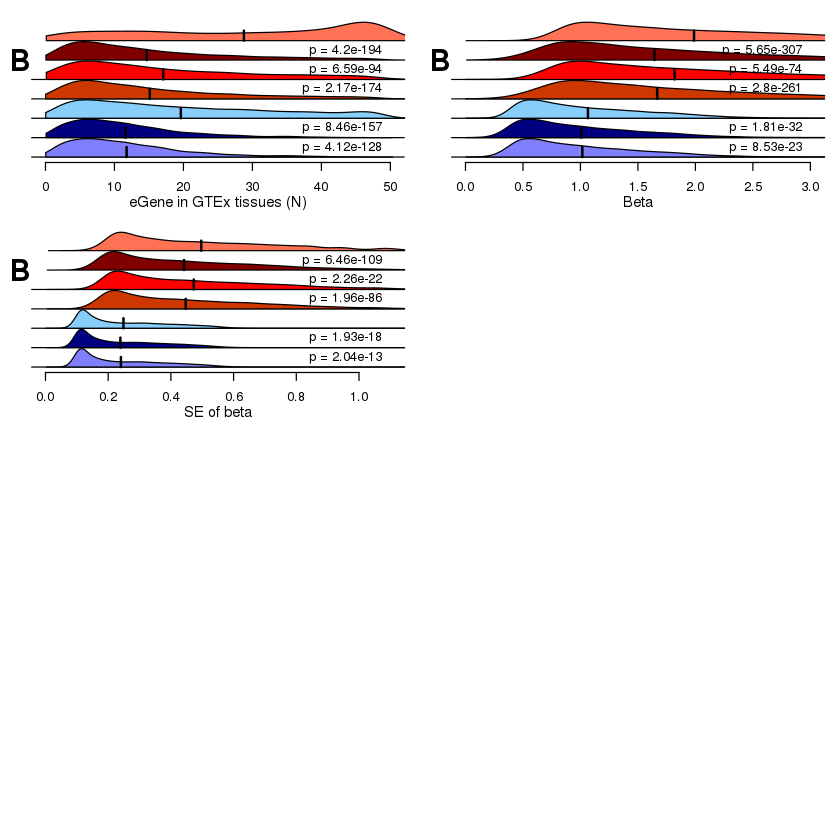

In [10]:
density_lines = function(x)
{
    if (length(x) > 0)
    {
        dens = density(x)
        dens = data.frame(x = dens$x, y = dens$y)
        dens = dens[dens$x >= 0,]
        
        dens = rbind(dens, data.frame(x = c(max(dens$x), min(dens$x)), y = c(0,0)))
        #dens = rbind(dens, data.frame(x = rev(xlim), y = c(0,0)))

        return(dens)
    }
}

polygon_density = function(dens, color, y0, yscale = 0.95)
{
    if (nrow(dens) > 0)
    {
        polygon(dens$x, (dens$y / max(dens$y) * yscale) + y0, col = color)
    }
}


plot_densities_gtex = function(qtls2n, column, filter, xmax, main, panel)
{
    if (filter == TRUE ){qtl2tissues_true  = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == TRUE , column]})}
    if (filter == TRUE ){qtl2tissues_false = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == FALSE, column]})}
    if (filter == FALSE){qtl2tissues_true  = lapply(qtls2n, function(x){x[, column]})}
    if (filter == FALSE){qtl2tissues_false = lapply(qtls2n, function(x){x[, column]})}
    names(qtl2tissues_true ) = names(qtl2tissues_true )
    names(qtl2tissues_false) = names(qtl2tissues_false)

    dens_list_true  = lapply(qtl2tissues_true , density_lines)
    dens_list_false = lapply(qtl2tissues_false, density_lines)

    tissue2name = tissue2name[order(tissue2name$y, decreasing = TRUE),]
    
    plot(1,1, type = "n", xlim = c(0, xmax), ylim = c(1,8), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    mtext(text = main, side = 1, line = 2, cex = 0.75)
    abline(h = 1:5)

    polygon_density(dens_list_true [["liver_original"]], tissue2name[tissue2name$tissue == "liver_original", "color"], 8 - 1)
    polygon_density(dens_list_false[["liver2_cells"  ]], tissue2name[tissue2name$tissue == "liver2_cells"  , "color"], 8 - 2)
    polygon_density(dens_list_false[["liver3_cells"  ]], tissue2name[tissue2name$tissue == "liver3_cells"  , "color"], 8 - 3)
    polygon_density(dens_list_false[["liver_cells"   ]], tissue2name[tissue2name$tissue == "liver_cells"   , "color"], 8 - 4)
    polygon_density(dens_list_true [["skin_original" ]], tissue2name[tissue2name$tissue == "skin_original" , "color"], 8 - 5)
    polygon_density(dens_list_false[["skin_cells"    ]], tissue2name[tissue2name$tissue == "skin_cells"    , "color"], 8 - 6)
    polygon_density(dens_list_false[["skin2_cells"   ]], tissue2name[tissue2name$tissue == "skin2_cells"   , "color"], 8 - 7)
    
    segments(x0 = c(mean(qtl2tissues_true [["liver_original"]]), 
                    mean(qtl2tissues_false[["liver2_cells"  ]]), 
                    mean(qtl2tissues_false[["liver3_cells"  ]]), 
                    mean(qtl2tissues_false[["liver_cells"   ]]), 
                    mean(qtl2tissues_true [["skin_original" ]]), 
                    mean(qtl2tissues_false[["skin_cells"    ]]), 
                    mean(qtl2tissues_false[["skin2_cells"    ]])), 
             y0 = 8 - (1:7), y1 = 9 - (1:7), col = "#000000", lty = "dashed", lwd = 2)

    #text(x = rep(xmax/2, 5), y = (5:1)+0.5, labels = tissue2name$name, pos = 3)
    mtext(text = panel, side = 2, line = 0, cex = 1.5 , at = 6, las = 1, font = 2)

    text(xmax, 6.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["liver2_cells"]], qtl2tissues_true[["liver_original"]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 5.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["liver3_cells"]], qtl2tissues_true[["liver_original"]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 4.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["liver_cells" ]], qtl2tissues_true[["liver_original"]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 2.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["skin_cells"  ]], qtl2tissues_true[["skin_original" ]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 1.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["skin2_cells" ]], qtl2tissues_true[["skin_original" ]])$p.value, digits = 3), sep = " = "), pos = 2)
    
    return(data.frame(tissue   = c("liver2_cells", "liver3_cells", "liver_cells", "skin_cells", "skin2_cells"), 
                      cells    = c(mean(qtl2tissues_false[["liver2_cells"  ]], na.rm = TRUE), mean(qtl2tissues_false[["liver3_cells"  ]], na.rm = TRUE), mean(qtl2tissues_false[["liver_cells"   ]], na.rm = TRUE), mean(qtl2tissues_false[["skin_cells"   ]], na.rm = TRUE), mean(qtl2tissues_false[["skin2_cells"  ]], na.rm = TRUE)),
                      original = c(mean(qtl2tissues_true [["liver_original"]], na.rm = TRUE), mean(qtl2tissues_true [["liver_original"]], na.rm = TRUE), mean(qtl2tissues_true [["liver_original"]], na.rm = TRUE), mean(qtl2tissues_true [["skin_original"]], na.rm = TRUE), mean(qtl2tissues_true [["skin_original"]], na.rm = TRUE))
                     ))
}

par(mfrow = c(4,2), mar = c(3,2,1,1))
plot_densities_gtex(qtls2n, "n"       , filter = TRUE , 50  , main = "eGene in GTEx tissues (N)", "B")
plot_densities_gtex(qtls2n, "abs_beta", filter = FALSE,  3  , main = "Beta"                     , "B")
plot_densities_gtex(qtls2n, "se"      , filter = FALSE,  1.1, main = "SE of beta"               , "B")



In [11]:
barplot_egenes = function(tissues, qtl_list, tissue2name)
{
    
    plot(1,1, type = "n", xlab = "", ylab = "", xlim = range(as.numeric(unlist(lapply(qtl_list, function(x){range(x$exp)})))), ylim = range(as.numeric(unlist(lapply(qtl_list, function(x){range(x$logp)})))))
    
    invisible(lapply(tissues, function(tissue){points(qtl_list[[tissue]][,"exp"], qtl_list[[tissue]][,"logp"], col = tissue2name[tissue2name$tissue == tissue, "color"], pch = 16)}))
}

#run_qqplot(tissues, qtl_list, tissue2name)


# Scatterplot QTLs

0.978320467875693
0.976226415021707
0.987722979923976
0.994229531882522
0.99572230925766


tissue,tissue1,tissue2,genes,ns,only1,only2,both
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>
liver,liver_original,liver_cells,17983,10743,0,5973,1267
liver,liver_original,liver2_cells,17757,8443,0,8068,1246
liver,liver_cells,liver2_cells,17832,8075,364,2491,6902
skin,skin_original,skin_cells,23240,11591,0,2653,8996
skin,skin_original,skin2_cells,23402,12167,0,2187,9048


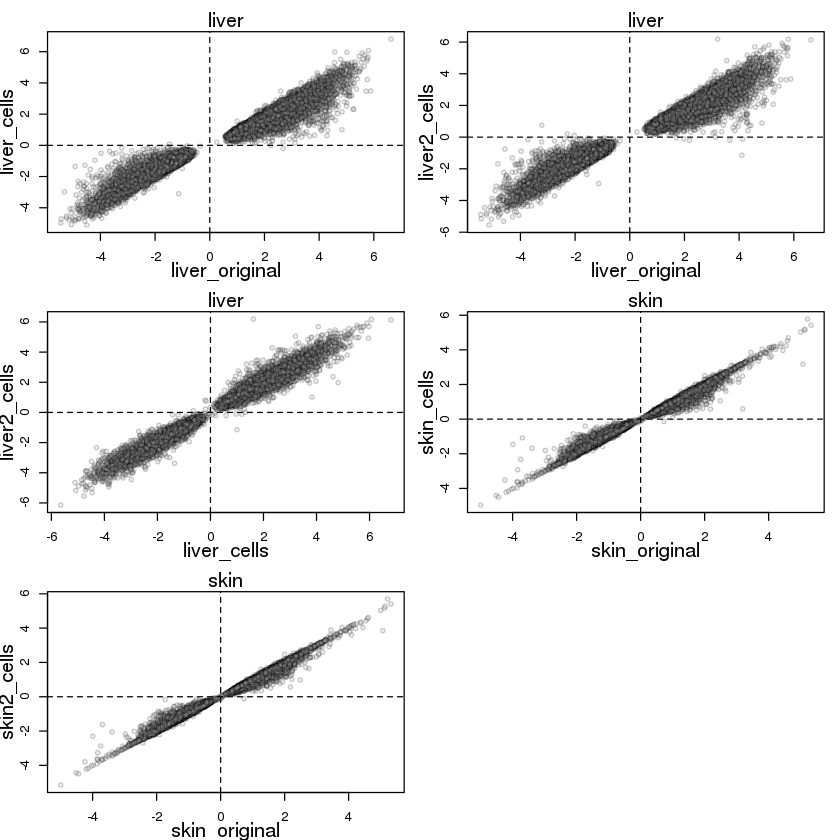

In [12]:
compare_qtls = function(tissue1, tissue2, tissue)
{
    qtls1 = read.table(paste("qtls/", tissue1, "/analysis/egenes.", tissue1, ".txt", sep = ""), header = TRUE)
    qtls2 = read.table(paste("qtls/", tissue2, "/analysis/egenes.", tissue2, ".txt", sep = ""), header = TRUE)
    qtls1$gene_var = paste(qtls1$gene_id, qtls1$id)
    qtls2$gene_var = paste(qtls2$gene_id, qtls2$id)
    
    qtls  = merge(qtls1[,c("gene_var", "egene", "beta", "se", "bonferroni")], qtls2[,c("gene_var", "egene", "beta", "se", "bonferroni")], by = "gene_var", suffixes = 1:2)
    
    qtls$color = "#aaaaaa"
    qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE , "color"] = "#ff0000"
    qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE, "color"] = "#ff00ff"
    qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE , "color"] = "#00ffff"
    qtls = rbind(qtls[qtls$egene1 == FALSE & qtls$egene2 == FALSE,],
                 qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE ,],
                 qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE ,],
                 qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE,]
                )
    
    message(cor(qtls$beta1, qtls$beta2))
    
    plot(qtls$beta1, qtls$beta2, bg = "#aaaaaa33", col = "#00000033", pch = 21, cex = 0.75, xlab = "", ylab = "", main = "")
    #smoothScatter(qtls$beta1, qtls$beta2, bg = qtls$color, xlab = "", ylab = "", main = "", nrpoints = 0)
    #points(qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE , "beta1"], qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE , "beta2"], bg = "#00ffff", pch = 21, cex = 0.75)
    #points(qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE, "beta1"], qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE, "beta2"], bg = "#ff00ff", pch = 21, cex = 0.75)
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
    mtext(text = tissue1, side = 1, line = 2  )
    mtext(text = tissue2, side = 2, line = 2  )
    mtext(text = tissue , side = 3, line = 0.1)
    
    #text(x = rep(min(qtls$beta1),5), y = (0:(-4)) + max(qtls$beta2), cex = 0.75, pos = 4,
    #     labels = c(paste("Genes", nrow(qtls1), sep = ": "),
    #                paste("Genes with the same top hit", nrow(qtls), sep = ": "),
    #                paste("eGenes", tissue1, "only:"   , nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE,]), sep = " "),
    #                paste("eGenes", tissue2, "only:"   , nrow(qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE ,]), sep = " "),
    #                paste("eGenes both tissues:"       , nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE ,]), sep = " ")))
    #
    #points(x = rep(min(qtls$beta1),3), y = (-2:(-4)) + max(qtls$beta2), pch = 21, bg = c("#ff00ff", "#00ffff", "#ff0000"))
    
    #legend("bottomright", pch = 21, pt.bg = c("#aaaaaa", "#ff00ff", "#00ffff", "#ff0000"),
    #       legend = c("Not significant", tissue1, tissue2, "Both"))
    
    write.table(qtls, file = paste("qtls", tissue1, tissue2, "txt", sep = "."), quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
    
    return(data.frame(tissue  = tissue,
                      tissue1 = tissue1, 
                      tissue2 = tissue2, 
                      genes   = nrow(qtls), 
                      ns      = nrow(qtls[qtls$egene1 == FALSE & qtls$egene2 == FALSE,]),
                      only1   = nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE,]),
                      only2   = nrow(qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE ,]),
                      both    = nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE ,])
                     ))
    
    #return(list(#qtls1      = qtls1, 
    #            #qtls2      = qtls2,
    #            ttest_beta = t.test(abs(qtls$beta2), abs(qtls$beta1), paired = TRUE),
    #            ttest_se   = t.test(qtls$se2  , qtls$se1  , paired = TRUE)))
}

par(mfrow = c(3,2), mar = c(3,3,2,1))

out1 = compare_qtls("liver_original", "liver_cells" , "liver")
out2 = compare_qtls("liver_original", "liver2_cells", "liver")
out3 = compare_qtls("liver_cells"   , "liver2_cells", "liver")
out4 = compare_qtls("skin_original" , "skin_cells"  , "skin" )
out5 = compare_qtls("skin_original" , "skin2_cells" , "skin" )

qtl2plot = rbind(out1, out2, out3, out4, out5)

qtl2plot

In [13]:
qtl2plot_data = function(tissue)
{
    qtls = read.table(paste("qtls/", tissue, "/analysis/egenes."     , tissue, ".txt", sep = ""), header = TRUE)
    
    out = data.frame(tissue = tissue, egenes = nrow(qtls[qtls$egene == TRUE,]), ns = nrow(qtls[qtls$egene == FALSE,]))
    
    return(out)
}

qtl2plot = do.call("rbind", lapply(c("liver_original", "liver_cells", "liver2_cells", "skin_original", "skin_cells", "skin2_cells"), qtl2plot_data))


# Add interaction terms

In [14]:
liver_cells  = c("endothelial", "hepatocyte", "kupffer_cell", "nk_cell")
liver2_cells = c("endothelial_venous", "gdt", "hepatocyte0", "hepatocyte3", "hepatocyte4", "macrophage", "nkt_cell", "endothelial_periportal")
liver3_cells = c("merged_endothelial", "merged_hepatocyte", "merged_macrophage", "merged_nk_nkt_cell", "merged_b_cell", 'merged_cholangiocyte', 'merged_heptatic_stellate_cell')
skin_cells   = c("outer_bulge","inner_bulge","epidermis_basal","epidermis","epidermis_stem_cell","leukocyte")
skin2_cells  = c("collapsed_leukocyte", "collapsed_fibroblast", "collapsed_keratinocyte")

liver2_cells = data.frame(celltypes = c('central_venous_sinusoidal_endothelial_cells', 'gdT_cell', 'Hepatocytes0', 'Hepatocytes3', 'Hepatocytes4', 'inflammatory_macrophages', 'NK.NKT_cell', 'Periportal_sinusoidal_endothelial_cells'),
                          name      = c("endothelial_venous"                         , "gdt"     , "hepatocyte0" , "hepatocyte3" , "hepatocyte4" , "macrophage"              , "nkt_cell"   , "endothelial_periportal"                 ),
                          color     = c("#00c2c0"                                    , "#fa9c00" , "#b53bc7"     ,  "#f1a8f2"    , "#ff4bcc"     , "#cdad02"                 , "#ff8e77"    , "#0075da"                                ))

liver3_cells = data.frame(celltypes = c("endothelial"       , "hepatocyte"       , "macrophage"       , "nkt_cell"          , "b_cell"       , "cholangiocyte"       , "heptatic_stellate_cell"       ),
                          name      = c("merged_endothelial", "merged_hepatocyte", "merged_macrophage", "merged_nk_nkt_cell", "merged_b_cell", 'merged_cholangiocyte', 'merged_heptatic_stellate_cell'),
                          color     = c("#00c2c0"           , "#fa9c00"          , "#b53bc7"          ,  "#f1a8f2"          , "#ff4bcc"      , "#cdad02"             , "#ff8e77"                      ))

liver_cells = data.frame(celltypes = c('endothelial_cell_of_hepatic_sinusoid', 'hepatocyte', 'Kupffer_cell', 'natural_killer_cell'),
                         name      = c("endothelial"                         , "hepatocyte", "kupffer_cell", "nk_cell"            ),
                         color     = c("#00c2c0"                             , "#b53bc7"   , "#f0d710"     , "#ff8e77"            ))

skin_cells = data.frame(celltypes = c("epidermis_basal"        , "epidermis"     , "outer_bulge", "inner_bulge", "leukocyte", "epidermis_stem_cell"   ),
                        name      = c("epidermis_basal"        , "epidermis"     , "outer_bulge", "inner_bulge", "leukocyte", "epidermis_stem_cell"   ),
                        color     = c("#a3a737"                , "#34ade3"       , "#663d94"    , "#b9a5cf"    , "#ef68a2"  , "orange"                ))
                                     
skin2_cells = data.frame(celltypes = c("collapsed_leukocyte", "collapsed_fibroblast", "collapsed_keratinocyte"),
                        name      = c("collapsed_leukocyte", "collapsed_fibroblast", "collapsed_keratinocyte"),
                        color     = c("#ef68a2"            , "#b9a5cf"             , "#663d94"               ))
                                     
cell2col = list(liver_cells = liver_cells, liver2_cells = liver2_cells, liver3_cells = liver3_cells, skin_cells = skin_cells, skin2_cells = skin2_cells)



In [15]:
check_interaction = function(tissue, cells)
{
    qtls = read.table(paste("qtls/", tissue, "/analysis/egenes."     , tissue, ".txt", sep = ""), header = TRUE)
    lmms = read.table(paste("qtls/", tissue, "/analysis/lmm_compare.", tissue, ".txt", sep = ""), header = TRUE, check.names = FALSE)
    
    tofdr = colnames(lmms)
    tofdr = tofdr[grepl("pval$", tofdr) == TRUE & tofdr != "min_pval"]
    

    for (x in tofdr)
    {
        lmms[,gsub("pval", "qval", x)] = qvalue(lmms[,x])$qvalues
    }
    
    write.table(lmms, paste("qtls/", tissue, "/analysis/lmm_compare_fdr.", tissue, ".txt", sep = ""), quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
    
    out   = cells
    out$n = 0
    
    for (ii in 1:nrow(out))
    {
        x = out[ii, "name"]
        out[ii, "n"] = nrow(lmms[lmms[,paste("gt", x, "qval", sep = ":")] < 0.1, ])
    }
    
    #barplot(out$n, names.arg = gsub("_", " ", out$celltypes), horiz = TRUE, col = out$color, las = 1)
    
    return(out)

}

tobar = lapply(c("liver_cells", "liver2_cells", "liver3_cells", "skin_cells", "skin2_cells"), function(x){check_interaction(x, cell2col[[x]])})
names(tobar) = c("liver_cells", "liver2_cells", "liver3_cells", "skin_cells", "skin2_cells")


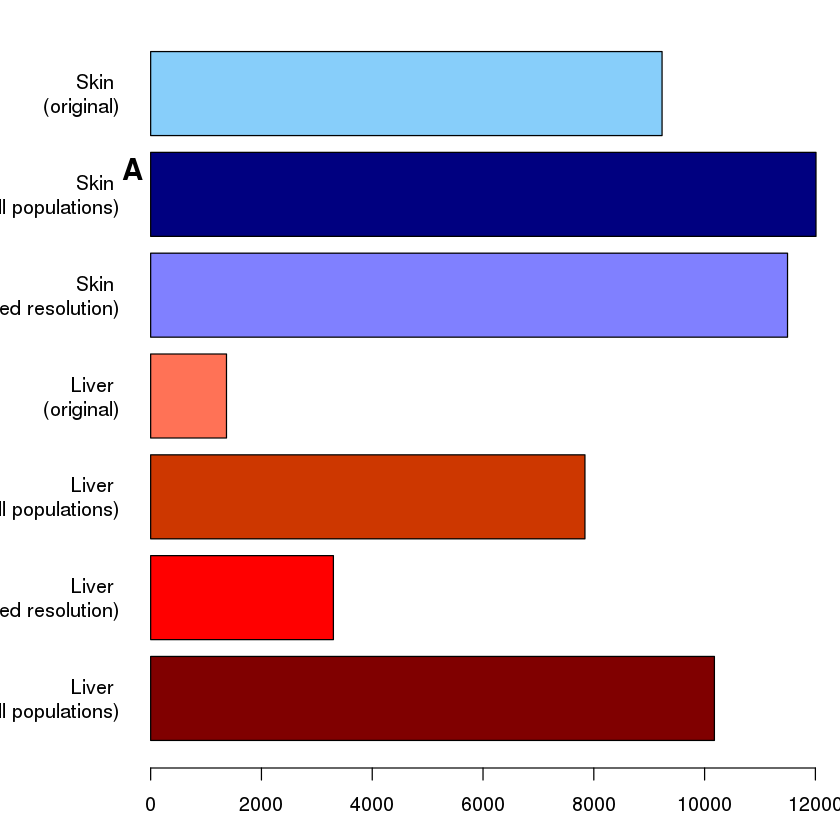

In [16]:



barplot_egenes = function(panel)
{
    barplot(egenes$egenes, names.arg = gsub("\\(", "\n(", egenes$name), horiz = TRUE, las = 1, col = egenes$color)
    mtext(text = panel, side = 2, line = 0, cex = 1.5 , at = 7, las = 1, font = 2)
    
}


par(mar = c(3,6,1,1))
barplot_egenes("A")


In [17]:
egenes
10177/1369


tissue,genes,egenes,name,color,y,main
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>
liver2_cells,19621,10177,Liver (human cell populations),#800000,5,liver
liver3_cells,19621,3299,Liver (collapsed resolution),#ff0000,4,liver
liver_cells,19621,7840,Liver (mouse cell populations),#CD3700,6,liver
liver_original,19621,1369,Liver (original),#FF7256,7,liver
skin2_cells,24029,11497,Skin (collapsed resolution),#8080ff,1,skin
skin_cells,24029,12011,Skin (mouse cell populations),#000080,2,skin
skin_original,24029,9232,Skin (original),#87CEFA,3,skin


[1] 7.433893

In [18]:
check_interaction_no_hashes = function(tissue, cells, name, panel)
{
    if (grepl("Liver", name) == TRUE){qtls2 = read.table(paste("qtls/", "liver_original", "/analysis/egenes.", "liver_original", ".txt", sep = ""), header = TRUE)}
    if (grepl("Skin" , name) == TRUE){qtls2 = read.table(paste("qtls/", "skin_original" , "/analysis/egenes.", "skin_original" , ".txt", sep = ""), header = TRUE)}
    if (grepl("Liver", name) == TRUE){xlims = c(0, 105)}
    if (grepl("Skin" , name) == TRUE){xlims = c(0, 270)}
    lmms = read.table(paste("qtls/", tissue, "/analysis/lmm_compare.", tissue, ".txt", sep = ""), header = TRUE, check.names = FALSE)
    
    lmms$original = FALSE
    lmms[lmms$gene_id %in% qtls2[qtls2$egene == TRUE, "gene_id"], "original"] = TRUE
    
    tofdr = colnames(lmms)
    tofdr = tofdr[grepl("pval$", tofdr) == TRUE & tofdr != "min_pval"]

    for (x in tofdr)
    {
        lmms[,gsub("pval", "qval", x)] = qvalue(lmms[,x])$qvalues
    }
    
    write.table(lmms, paste("qtls/", tissue, "/analysis/lmm_compare_fdr.", tissue, ".txt", sep = ""), quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
    
    out   = cells
    out$n = 0
    for (ii in 1:nrow(out))
    {
        x = out[ii, "name"]
        out[ii, "n"] = nrow(lmms[lmms[,paste("gt", x, "qval", sep = ":")] < 0.1, ])
    }
    
    #barplot(out$n, names.arg = gsub("_", " ", out$celltypes), horiz = TRUE, col = out$color, las = 1)
    
    plot(1,1, type = "n", ylim = c(0.5, nrow(out) + 0.5), xlim = c(0, max(out$n)), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    axis(2, at = 1:nrow(out), labels = gsub("_", " ", out$celltypes), las = 1)
    
    rect(xleft = 0, xright = out$n, ybottom = 1:nrow(out) - 0.4, ytop = 1:nrow(out) + 0.4, col = out[, "color"])

    mtext(text = paste(name, "(N eGenes)"), side = 1, line = 2  , cex = 0.75)
    mtext(text = panel                    , side = 2, line = 9  , cex = 1.5, at = nrow(out) + 0.5, las = 1, font = 2)
    return(out)

}

plot_densities_gtex = function(qtls2n, column, filter, xmax, main, panel)
{
    if (filter == TRUE ){qtl2tissues_true  = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == TRUE , column]})}
    if (filter == TRUE ){qtl2tissues_false = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == FALSE, column]})}
    if (filter == FALSE){qtl2tissues_true  = lapply(qtls2n, function(x){x[, column]})}
    if (filter == FALSE){qtl2tissues_false = lapply(qtls2n, function(x){x[, column]})}
    names(qtl2tissues_true ) = names(qtl2tissues_true )
    names(qtl2tissues_false) = names(qtl2tissues_false)

    dens_list_true  = lapply(qtl2tissues_true , density_lines)
    dens_list_false = lapply(qtl2tissues_false, density_lines)

    tissue2name = tissue2name[order(tissue2name$y, decreasing = TRUE),]
    
    plot(1,1, type = "n", xlim = c(0, xmax), ylim = c(1,8), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    mtext(text = main, side = 1, line = 2, cex = 0.75)
    abline(h = 1:6)

    polygon_density(dens_list_true [["liver_original"]], tissue2name[tissue2name$tissue == "liver_original", "color"], 8 - 1)
    polygon_density(dens_list_false[["liver2_cells"  ]], tissue2name[tissue2name$tissue == "liver2_cells"  , "color"], 8 - 2)
    polygon_density(dens_list_false[["liver3_cells"  ]], tissue2name[tissue2name$tissue == "liver3_cells"  , "color"], 8 - 3)
    polygon_density(dens_list_false[["liver_cells"   ]], tissue2name[tissue2name$tissue == "liver_cells"   , "color"], 8 - 4)
    polygon_density(dens_list_true [["skin_original" ]], tissue2name[tissue2name$tissue == "skin_original" , "color"], 8 - 5)
    polygon_density(dens_list_false[["skin_cells"    ]], tissue2name[tissue2name$tissue == "skin_cells"    , "color"], 8 - 6)
    polygon_density(dens_list_false[["skin2_cells"   ]], tissue2name[tissue2name$tissue == "skin2_cells"   , "color"], 8 - 7)
    
    segments(x0 = c(mean(qtl2tissues_true [["liver_original"]]), 
                    mean(qtl2tissues_false[["liver2_cells"  ]]), 
                    mean(qtl2tissues_false[["liver3_cells"  ]]), 
                    mean(qtl2tissues_false[["liver_cells"   ]]), 
                    mean(qtl2tissues_true [["skin_original" ]]), 
                    mean(qtl2tissues_false[["skin_cells"    ]]), 
                    mean(qtl2tissues_false[["skin2_cells"   ]])), 
             y0 = 8 - (1:7), y1 = 9 - (1:7), col = "#000000", lty = "dashed", lwd = 2)

    #text(x = rep(xmax/2, 5), y = (5:1)+0.5, labels = tissue2name$name, pos = 3)
    mtext(text = panel, side = 2, line = 0.5, cex = 1.5 , at = 8, las = 1, font = 2)

    text(xmax, 6.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["liver2_cells"]], qtl2tissues_true[["liver_original"]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 5.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["liver3_cells"]], qtl2tissues_true[["liver_original"]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 4.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["liver_cells" ]], qtl2tissues_true[["liver_original"]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 2.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["skin_cells"  ]], qtl2tissues_true[["skin_original" ]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 1.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["skin2_cells" ]], qtl2tissues_true[["skin_original" ]])$p.value, digits = 3), sep = " = "), pos = 2)
    
    return(data.frame(main     = main,
                      tissue   = c("liver2_cells", "liver3_cells", "liver_cells", "skin_cells", "skin2_cells"), 
                      cells    = c(mean(qtl2tissues_false[["liver2_cells"  ]], na.rm = TRUE), mean(qtl2tissues_false[["liver3_cells"  ]], na.rm = TRUE), mean(qtl2tissues_false[["liver_cells"   ]], na.rm = TRUE), mean(qtl2tissues_false[["skin_cells"   ]], na.rm = TRUE), mean(qtl2tissues_false[["skin2_cells"  ]], na.rm = TRUE)),
                      original = c(mean(qtl2tissues_true [["liver_original"]], na.rm = TRUE), mean(qtl2tissues_true [["liver_original"]], na.rm = TRUE), mean(qtl2tissues_true [["liver_original"]], na.rm = TRUE), mean(qtl2tissues_true [["skin_original"]], na.rm = TRUE), mean(qtl2tissues_true [["skin_original"]], na.rm = TRUE))
                     ))
}

check_interaction = function(tissue, cells, name, panel)
{
    if (grepl("Liver", name) == TRUE){qtls2 = read.table(paste("qtls/", "liver_original", "/analysis/egenes.", "liver_original", ".txt", sep = ""), header = TRUE)}
    if (grepl("Skin" , name) == TRUE){qtls2 = read.table(paste("qtls/", "skin_original" , "/analysis/egenes.", "skin_original" , ".txt", sep = ""), header = TRUE)}
    if (grepl("Liver", name) == TRUE){xlims = c(0, 105)}
    if (grepl("Skin" , name) == TRUE){xlims = c(0, 400)}
    lmms = read.table(paste("qtls/", tissue, "/analysis/lmm_compare.", tissue, ".txt", sep = ""), header = TRUE, check.names = FALSE)
    
    lmms$original = FALSE
    lmms[lmms$gene_id %in% qtls2[qtls2$egene == TRUE, "gene_id"], "original"] = TRUE
    
    tofdr = colnames(lmms)
    tofdr = tofdr[grepl("pval$", tofdr) == TRUE & tofdr != "min_pval"]

    for (x in tofdr)
    {
        lmms[,gsub("pval", "qval", x)] = qvalue(lmms[,x])$qvalues
    }
    
    lmms$n_signif = apply(lmms[, paste("gt", cells$name, "qval", sep = ":")], 1, function(x){length(x[x<0.1])})
    
    write.table(lmms, paste("qtls/", tissue, "/analysis/lmm_compare_fdr.", tissue, ".txt", sep = ""), quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
    
    out   = cells
    out$n = 0
    out$shared = 0
    for (ii in 1:nrow(out))
    {
        x = out[ii, "name"]
        out[ii, "n"     ] = nrow(lmms[lmms[,paste("gt", x, "qval", sep = ":")] < 0.1, ])
        out[ii, "shared"] = nrow(lmms[lmms[,paste("gt", x, "qval", sep = ":")] < 0.1 & lmms$n_signif == 1, ])
    }
    
    #plot(1,1, type = "n", ylim = c(0.5, nrow(out) + 0.5), xlim = c(0, max(out$n)), xlab = "", ylab = "", axes = FALSE)
    plot(1,1, type = "n", ylim = c(0.5, nrow(out) + 0.5), xlim = c(0, 420), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    axis(2, at = 1:nrow(out), labels = gsub("_", " ", out$celltypes), las = 1)
    
    rect(xleft = 0, xright = out$n     , ybottom = 1:nrow(out) - 0.4, ytop = 1:nrow(out) + 0.4, col = out[, "color"])
    rect(xleft = 0, xright = out$shared, ybottom = 1:nrow(out) - 0.4, ytop = 1:nrow(out) + 0.4, col = NA            , density = 10)

    mtext(text = paste(name, "(N eGenes)"), side = 1, line = 2  , cex = 0.75)
    mtext(text = panel                    , side = 2, line = 8.5, cex = 1.5, at = nrow(out) + 0.5, las = 1, font = 2)
    
    out$tissue = tissue
    out$all    = length(unique(lmms[lmms$n_signif > 0, "gene_id"]))
    return(out)

}


barplot_egenes = function(panel)
{
    egenes = egenes[order(egenes$y, decreasing = FALSE),]
    barplot(egenes$egenes, names.arg = gsub("\\(", "\n(", egenes$name), horiz = TRUE, las = 1, col = egenes$color)
    mtext(text = panel, side = 2, line = 7.5, cex = 1.5 , at = 8.5, las = 1, font = 2)
    mtext(text = "eGenes (N)", side = 1, line = 2, cex = 0.75)
}


liver3_cells = data.frame(celltypes = c("Endothelial_cell"  , "Hepatocyte"       , "Macrophage"       , "NK_cell"           , "B_cell"       , "Cholangiocyte"       , "Heptatic_stellate_cell"       ),
                          name      = c("merged_endothelial", "merged_hepatocyte", "merged_macrophage", "merged_nk_nkt_cell", "merged_b_cell", 'merged_cholangiocyte', 'merged_heptatic_stellate_cell'),
                          color     = c("#00c2c0"           , "#fa9c00"          , "#b53bc7"          ,  "#f1a8f2"          , "#ff4bcc"      , "#cdad02"             , "#ff8e77"                      ))

liver2_cells = data.frame(celltypes = c('Central_venous\nsinusoidal\nendothelial_cells', 'gdT_cell', 'Hepatocytes0', 'Hepatocytes3', 'Hepatocytes4', 'Inflammatory\nmacrophages', 'NK/NKT_cell', 'Periportal_sinusoidal\nendothelial_cells'),
                          name      = c("endothelial_venous"                           , "gdt"     , "hepatocyte0" , "hepatocyte3" , "hepatocyte4" , "macrophage"               , "nkt_cell", "endothelial_periportal"                 ),
                          color     = c("#00c2c0"                                      , "#fa9c00" , "#b53bc7"     ,  "#f1a8f2"    , "#ff4bcc"     , "#cdad02"                  , "#ff8e77" , "#0075da"                                ))

liver_cells = data.frame(celltypes = c('Endothelial_cell\nof_hepatic_sinusoid', 'Hepatocyte', 'Kupffer_cell', 'NK_cell'),
                         name      = c("endothelial"                          , "hepatocyte", "kupffer_cell", "nk_cell"),
                         color     = c("#00c2c0"                              , "#b53bc7"   , "#f0d710"     , "#ff8e77"))

skin_cells = data.frame(celltypes = c("epidermis_basal"        , "epidermis"     , "outer_bulge", "inner_bulge", "leukocyte", "epidermis_stem_cell"   ),
                        name      = c("epidermis_basal"        , "epidermis"     , "outer_bulge", "inner_bulge", "leukocyte", "epidermis_stem_cell"   ),
                        color     = c("#a3a737"                , "#34ade3"       , "#663d94"    , "#b9a5cf"    , "#ef68a2"  , "orange"                ))

liver2_cells = data.frame(celltypes = c('Venous_endothelial', 'gdT_cell', 'Hepatocytes0', 'Hepatocytes3', 'Hepatocytes4', 'Macrophages', 'NK/NKT_cell', 'Periportal_endothelial'),
                          name      = c("endothelial_venous", "gdt"     , "hepatocyte0" , "hepatocyte3" , "hepatocyte4" , "macrophage" , "nkt_cell"   , "endothelial_periportal"),
                          color     = c("#00c2c0"           , "#fa9c00" , "#b53bc7"     ,  "#f1a8f2"    , "#ff4bcc"     , "#cdad02"    , "#ff8e77"    , "#0075da"               ))

liver_cells = data.frame(celltypes = c('Endothelial', 'Hepatocyte', 'Kupffer_cell', 'NK_cell'),
                         name      = c("endothelial", "hepatocyte", "kupffer_cell", "nk_cell"),
                         color     = c("#00c2c0"    , "#b53bc7"   , "#f0d710"     , "#ff8e77"))

skin2_cells = data.frame(celltypes = c("collapsed_leukocyte", "collapsed_fibroblast", "collapsed_keratinocyte"),
                        name      = c("collapsed_leukocyte", "collapsed_fibroblast", "collapsed_keratinocyte"),
                        color     = c("#ef68a2"            , "#b9a5cf"             , "#663d94"               ))

#cell2col = list(liver_cells = liver_cells, liver2_cells = liver2_cells, liver3_cells = liver3_cells, skin_cells = skin_cells, skin2_cells = skin2_cells, font = 2)
cell2col = list(liver_cells = liver_cells, liver2_cells = liver2_cells, liver3_cells = liver3_cells, skin_cells = skin_cells, skin2_cells = skin2_cells)



options(repr.plot.width=8.5, repr.plot.height=11)

pdf(file = "Figure4.pdf", width = 8.5, height = 11)
layout(rbind(c(1,2), c(3,4), c(5,6), c(5,7), c(8,9)))

par(mar = c(3,10,1,1))
barplot_egenes("A")

par(mar = c(3,2,1,1))
outb1 = plot_densities_gtex(qtls2n, "n"       , filter = TRUE , 50  , main = "eGene in GTEx tissues (N)", "B")
outb2 = plot_densities_gtex(qtls2n, "abs_beta", filter = FALSE,  3  , main = "Beta"                     , "C")
outb3 = plot_densities_gtex(qtls2n, "se"      , filter = FALSE,  1.1, main = "SE of beta"               , "D")

par(mar = c(3,10,1,1))

out2 = check_interaction("liver2_cells", cell2col[["liver2_cells"]], "Liver (high resolution)"     , "E")
out4 = check_interaction("liver3_cells", cell2col[["liver3_cells"]], "Liver (collapsed resolution)", "F")
out1 = check_interaction("liver_cells" , cell2col[["liver_cells" ]], "Liver (low resolution)"      , "G")
out3 = check_interaction("skin_cells"  , cell2col[["skin_cells"  ]], "Skin (deconvoluted)"         , "H")
out5 = check_interaction("skin2_cells" , cell2col[["skin2_cells" ]], "Skin (collapsed resolution)" , "I")

cell2cell = rbind(out1, out2, out4, out3, out5)

distr = rbind(outb1, outb2, outb3)

dev.off()

png 
  2

In [19]:
out5

celltypes,name,color,n,shared,tissue,all
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>
collapsed_leukocyte,collapsed_leukocyte,#ef68a2,414,103,skin2_cells,511
collapsed_fibroblast,collapsed_fibroblast,#b9a5cf,9,1,skin2_cells,511
collapsed_keratinocyte,collapsed_keratinocyte,#663d94,407,91,skin2_cells,511


In [20]:
cell2cell$spec = cell2cell$n - cell2cell$shared

aggregate(shared ~ tissue + all, data = cell2cell, FUN = sum)

cell2cell

tissue,all,shared
<chr>,<int>,<dbl>
liver2_cells,74,54
liver_cells,121,68
skin_cells,384,375
skin2_cells,511,195
liver3_cells,528,220


celltypes,name,color,n,shared,tissue,all,spec
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>
Endothelial,endothelial,#00c2c0,41,6,liver_cells,121,35
Hepatocyte,hepatocyte,#b53bc7,96,43,liver_cells,121,53
Kupffer_cell,kupffer_cell,#f0d710,5,2,liver_cells,121,3
NK_cell,nk_cell,#ff8e77,46,17,liver_cells,121,29
Venous_endothelial,endothelial_venous,#00c2c0,3,2,liver2_cells,74,1
gdT_cell,gdt,#fa9c00,1,1,liver2_cells,74,0
Hepatocytes0,hepatocyte0,#b53bc7,56,36,liver2_cells,74,20
Hepatocytes3,hepatocyte3,#f1a8f2,0,0,liver2_cells,74,0
Hepatocytes4,hepatocyte4,#ff4bcc,27,10,liver2_cells,74,17


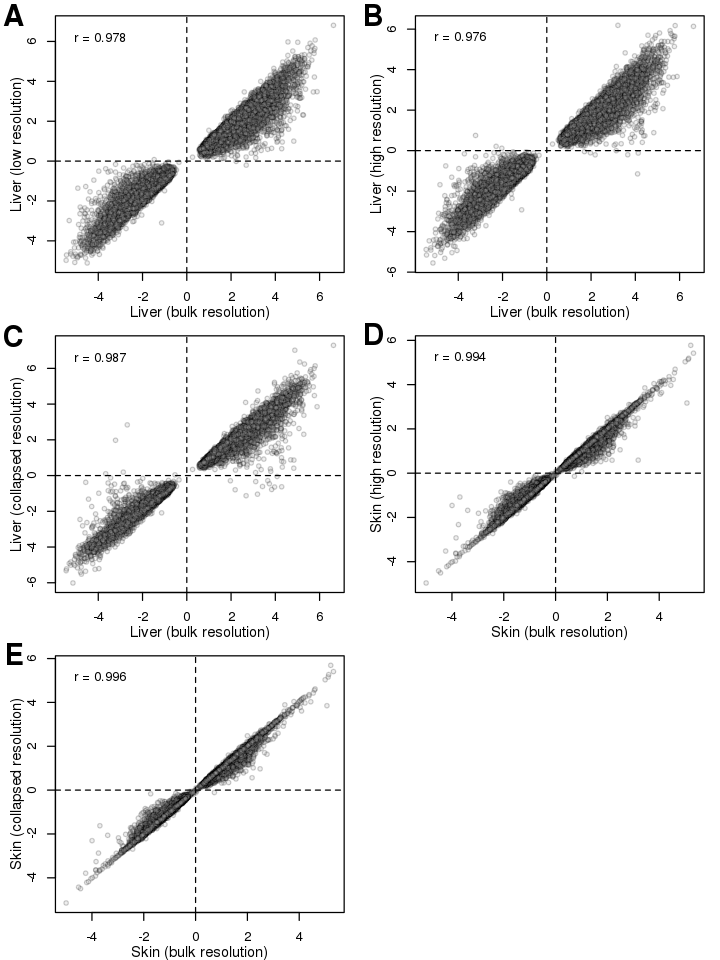

In [21]:
compare_qtls = function(tissue1, tissue2, tissue, name1, name2, panel)
{
    qtls1          = read.table(paste("qtls/", tissue1, "/analysis/egenes.", tissue1, ".txt", sep = ""), header = TRUE)
    qtls2          = read.table(paste("qtls/", tissue2, "/analysis/egenes.", tissue2, ".txt", sep = ""), header = TRUE)
    qtls1$gene_var = paste(qtls1$gene_id, qtls1$id)
    qtls2$gene_var = paste(qtls2$gene_id, qtls2$id)
    qtls           = merge(qtls1[,c("gene_var", "egene", "beta", "se", "bonferroni")], qtls2[,c("gene_var", "egene", "beta", "se", "bonferroni")], by = "gene_var", suffixes = 1:2)
    
    plot(qtls$beta1, qtls$beta2, bg = "#aaaaaa33", col = "#00000033", pch = 21, cex = 0.75, xlab = "", ylab = "", main = "")
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
    mtext(text = name1, side = 1, line = 2  , cex = 0.75)
    mtext(text = name2, side = 2, line = 2  , cex = 0.75)
    mtext(text = panel, side = 2, line = 1.9, cex = 1.5 , at = max(qtls$beta2) + 0.5, las = 1, font = 2)
    
    text(x = min(qtls$beta1), y = max(qtls$beta2) * 0.9, labels = paste("r", signif(cor(qtls$beta1, qtls$beta2), digits = 3), sep = " = "), pos = 4)
}


options(repr.plot.width=6, repr.plot.height=8)

layout(rbind(c(1,2), c(3,4), c(5,6)))

par(mar = c(3,3.5,1,1))

compare_qtls("liver_original", "liver_cells" , "liver", "Liver (bulk resolution)", "Liver (low resolution)"      , "A")
compare_qtls("liver_original", "liver2_cells", "liver", "Liver (bulk resolution)", "Liver (high resolution)"     , "B")
compare_qtls("liver_original", "liver3_cells", "liver", "Liver (bulk resolution)", "Liver (collapsed resolution)", "C")
compare_qtls("skin_original" , "skin_cells"  , "skin" , "Skin (bulk resolution)" , "Skin (high resolution)"      , "D")
compare_qtls("skin_original" , "skin2_cells" , "skin" , "Skin (bulk resolution)" , "Skin (collapsed resolution)" , "E")


In [81]:
no_orig     = tissue2name[grepl("original", tissue2name$tissue) == FALSE, ]
lmms        = lapply(no_orig$tissue, function(tissue){read.table(paste("qtls/", tissue, "/analysis/lmm_compare_fdr.", tissue, ".txt", sep = ""), header = TRUE, check.names = FALSE)})
names(lmms) = no_orig$tissue

In [82]:
find_signif = function(x)
{
    out = x[x$n_signif > 0, "gene_id"]
    return(out)
}

liver = unique(c(unlist(lapply(lmms[no_orig[grepl("liver", no_orig$tissue) == TRUE, "tissue"]], find_signif))))
skin  = unique(c(unlist(lapply(lmms[no_orig[grepl("skin" , no_orig$tissue) == TRUE, "tissue"]], find_signif))))

length(liver)
length(skin )

length(unique(c(liver, skin)))

[1] 657

[1] 617

[1] 1255

In [83]:
liver = lapply(lmms[no_orig[grepl("liver", no_orig$tissue) == TRUE, "tissue"]], find_signif)
a = as.data.frame(table(c(unlist(lapply(lmms[no_orig[grepl("liver", no_orig$tissue) == TRUE, "tissue"]], find_signif)))), stringsAsFactors = FALSE)

In [84]:
head(a)

Var1,Freq
<chr>,<int>
ENSG00000002549.8,1
ENSG00000002726.15,2
ENSG00000004660.10,1
ENSG00000004864.9,1
ENSG00000005421.4,1
ENSG00000006047.8,1


In [85]:
table(a$Freq)


  1   2   3 
603  42  12 

In [86]:
lapply(lmms[no_orig[grepl("liver", no_orig$tissue) == TRUE, "tissue"]], function(x){length(find_signif(x))})
121/74
528/74

$liver_cells
[1] 121

$liver2_cells
[1] 74

$liver3_cells
[1] 528

[1] 1.635135

[1] 7.135135

In [87]:
egenes

tissue,genes,egenes,name,color,y,main
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>
liver2_cells,19621,10177,Liver (human cell populations),#800000,5,liver
liver3_cells,19621,3299,Liver (collapsed resolution),#ff0000,4,liver
liver_cells,19621,7840,Liver (mouse cell populations),#CD3700,6,liver
liver_original,19621,1369,Liver (original),#FF7256,7,liver
skin2_cells,24029,11497,Skin (collapsed resolution),#8080ff,1,skin
skin_cells,24029,12011,Skin (mouse cell populations),#000080,2,skin
skin_original,24029,9232,Skin (original),#87CEFA,3,skin


In [88]:
fisher.test(matrix(c(121, 7840-121, 74, 10177 - 74), nrow = 2))
fisher.test(matrix(c(528, 3299-528, 74, 10177 - 74), nrow = 2))$p.value



	Fisher's Exact Test for Count Data

data:  matrix(c(121, 7840 - 121, 74, 10177 - 74), nrow = 2)
p-value = 1.922e-07
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.586861 2.902298
sample estimates:
odds ratio 
  2.140074 


[1] 7.138156e-250

In [89]:

out       = rbind(out1, out2, out3)
out$tot   = out$n
out$ratio = (out$n - out$shared) / out$tot

out_dt = data.table(out)

totest = data.frame(out_dt[ , .(sum = sum(tot), mean = mean(tot), mean_ratio = mean(ratio), unique = sum(unique), shared = sum(n), .N), by = .(tissue)] )
#totest = merge(totest, egenes[,c("genes", "egenes", "name")], by.x = "tissue", by.y = "name")
#totest$not = totest$egenes - totest$sum
#totest$original = c(1369, 1369, 9232)
#
#totest$not_unique   = totest$egenes   - totest$unique
#totest$not_original = totest$original - totest$shared
#
#fisher.test(as.matrix(totest[totest$tissue %in% c("Liver (high resolution)", "Liver (low resolution)"), c("sum", "not")]))
#fisher.test(as.matrix(totest[totest$tissue %in% c("Liver (high resolution)", "Liver (low resolution)"), c("sum", "not")]))$p.value
#
#fisher.test(matrix(as.numeric(totest[totest$tissue == "Liver (high resolution)", c("unique", "not_unique", "shared", "not_original")]), nrow = 2))
#fisher.test(matrix(as.numeric(totest[totest$tissue == "Liver (low resolution)" , c("unique", "not_unique", "shared", "not_original")]), nrow = 2))
#fisher.test(matrix(as.numeric(totest[totest$tissue == "Skin (deconvoluted)"    , c("unique", "not_unique", "shared", "not_original")]), nrow = 2))
#
#
#sum(totest$sum)
#
#totest$unique/totest$egenes
#totest$shared/totest$original
#
#
#totest

ERROR: Error in gsum(unique): GForce sum can only be applied to columns, not .SD or similar. To sum all items in a list such as .SD, either add the prefix base::sum(.SD) or turn off GForce optimization using options(datatable.optimize=1). More likely, you may be looking for 'DT[,lapply(.SD,sum),by=,.SDcols=]'


In [ ]:
as.numeric(totest[totest$tissue == "Liver (high resolution)", c("unique", "not_unique", "shared", "not_original")])